In [1]:
%matplotlib inline
import matplotlib
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import sys
import os
#pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from skimage.draw import polygon
import json
import matplotlib.image as mpimg

coco_dir = 'coco/images/'
annotation_dir = 'coco/'
dataType = 'val2014'
annFile='{}/annotations/instances_{}.json'.format(annotation_dir,dataType)
cocoImgDir = '{}/images/{}/'.format(annotation_dir, dataType)

In [2]:
# initialize COCO api for instance annotations
dataset_type = 'instances'
dataset = json.load(open(annFile, 'r'))

#not sure why this field not saved in my annotations?
if 'type' not in dataset.keys():
    dataset['type'] = dataset_type
    with open(annFile, 'w') as outfile:
        json.dump(dataset, outfile)

coco=COCO(annFile)

loading annotations into memory...
0:00:05.407070
creating index...
index created!


In [3]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms='person');
person_id = catIds[0]
imgIds = coco.getImgIds(catIds=person_id);
imgId = imgIds[np.random.randint(0,len(imgIds))]
#imgId = 512657
img = coco.loadImgs(imgId)[0]

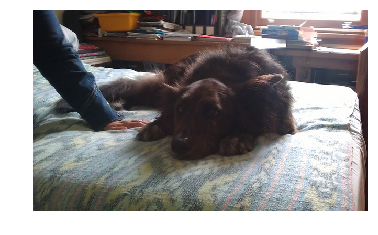

In [4]:
# load and display image
fig = plt.figure(frameon=False)
I=mpimg.imread('%s/COCO_%s_%012d.jpg' %(cocoImgDir, dataType, imgId))
plt.axis('off')
plt.imshow(I)

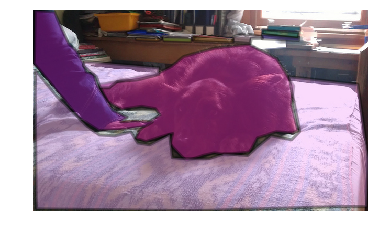

In [5]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [6]:
def get_polygons(anns, catIds=[]):
    polygons = []
    for ann in anns:
        if ann['category_id'] in catIds:
            # polygon
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((len(seg)/2, 2))
                polygons.append(Polygon(poly, True,alpha=0.4))
    return polygons    

In [7]:
#get stuff to process image
colors = (0,0,0,1)
color_option = 'black' #other option 'average'
lines = open('/data/lisaanne/fairness/data/img_names.txt', 'r').readlines()
imgIds = [int(line) for line in lines]
imgIds = list(set(imgIds) & set(coco.getImgIds()))

0/10923

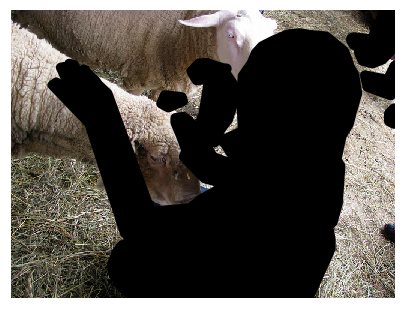

In [8]:
for i, imgId in enumerate([imgIds[0]]):
    sys.stdout.write('\r%d/%d' %(i, len(imgIds)))
    img = coco.loadImgs(imgId)[0]
    save_file = '/data/lisaanne/fairness/images/blocked_images_inv_%s/%d_%s.png' %(color_option, img['id'], color_option)
    if not os.path.isfile(save_file):
        
        fig = Figure()
        canvas = FigureCanvas(fig)
        ax = fig.gca()

        
        I=mpimg.imread('%s/COCO_%s_%012d.jpg' %(cocoImgDir, dataType, imgId))
        # load and display instance annotations
        plt.cla()
        plt.imshow(I); #plt.axis('off')
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=False)
        anns = coco.loadAnns(annIds)
        polygons = get_polygons(anns, [person_id])

        #code to make color average of scene
        if color_option == 'average':
            colors = []
            if I.ndim == 2:
                I = np.tile(I[..., np.newaxis], (1, 1, 3))
            for channel in range(3):
                colors.append(np.mean(I[:,:,channel])/255.)
        p = PatchCollection(polygons, facecolors=tuple(colors), edgecolors=tuple(colors), linewidths=10)

        ax = plt.gca()
        ax.add_collection(p)
        ax.set_axis_off()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
        ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

        plt.savefig(save_file, bbox_inches='tight', pad_inches=-0.05)

In [ ]:
coco.getImgIds()